In [44]:
import subprocess
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [45]:
def initialize_experiment() -> None:
    subprocess.run(["make"])

def run_experiment(graph_type: str, strategy: str, distribution: str, d_value: int, requests_number: int, repetitions: int) -> float:
    result = subprocess.run(f"./experiment {graph_type} {strategy} {distribution} {d_value} {requests_number} {repetitions}",
                            shell=True, capture_output=True, text=True)
    return float(result.stdout)

def clean_experiment() -> None:
    subprocess.run(["make", "clean"])

In [46]:
GRAPH_TYPES = ["hypercube", "torus"]
STRATEGIES = ["move_to_min", "coin_flip"]
DISTRIBUTIONS = ["uniform", "harmonic", "biharmonic"]
D_VALUES = [16, 32, 64, 128, 256]
REQUESTS_NUMBER = 65536
REPS = 100

initialize_experiment()

results = []
for strategy in STRATEGIES:
    for distribution in DISTRIBUTIONS:
        for graph_type in GRAPH_TYPES:
            for d_value in D_VALUES:
                result = run_experiment(graph_type, strategy, distribution, d_value, REQUESTS_NUMBER, REPS)
                results.append([
                    strategy, distribution, graph_type, d_value, result
                ])
results_df = pd.DataFrame(results, columns=["strategy", "distribution", "graph_type", "d_value", "result"])

with open("results.pkl", "wb") as f:
    pickle.dump(results_df, f)
        
clean_experiment()

g++ -std=c++17 -Wall -Wextra -Werror -pedantic -O3 main.cpp -o experiment
rm -f experiment


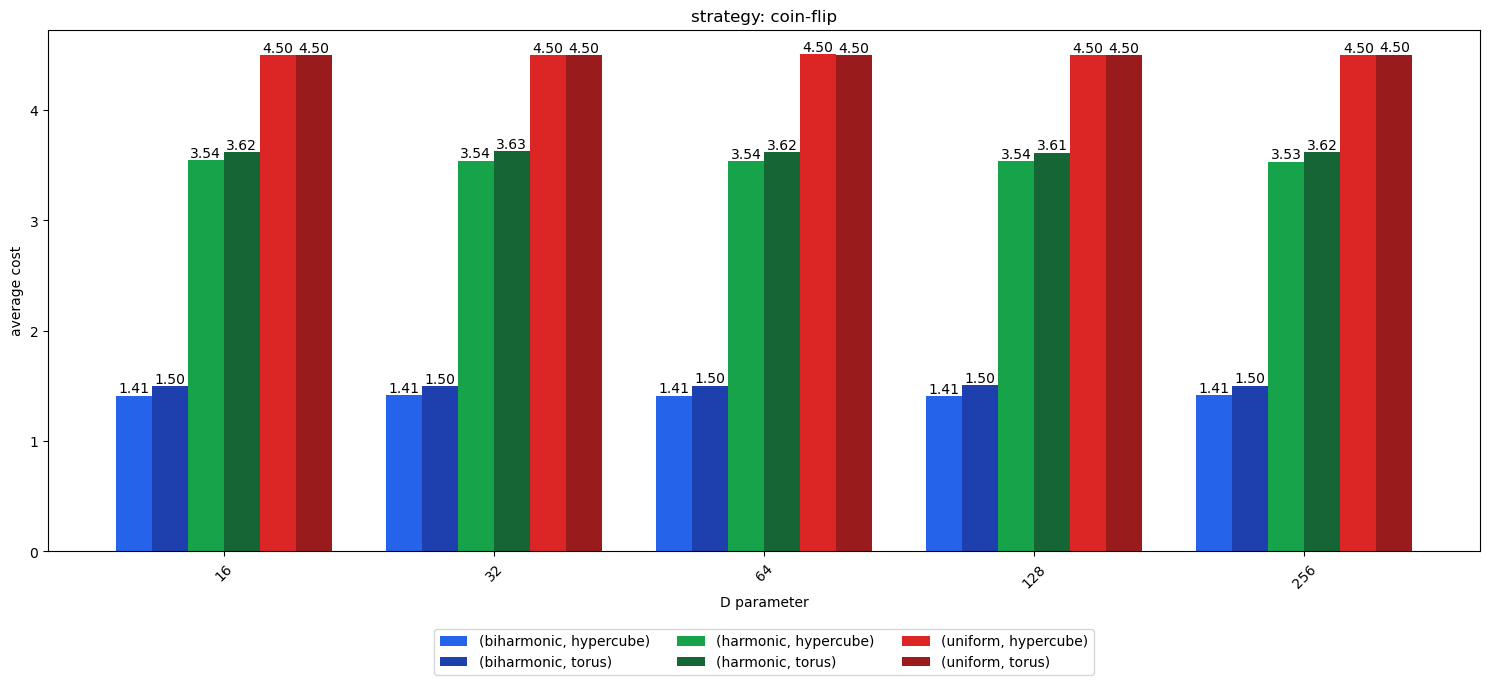

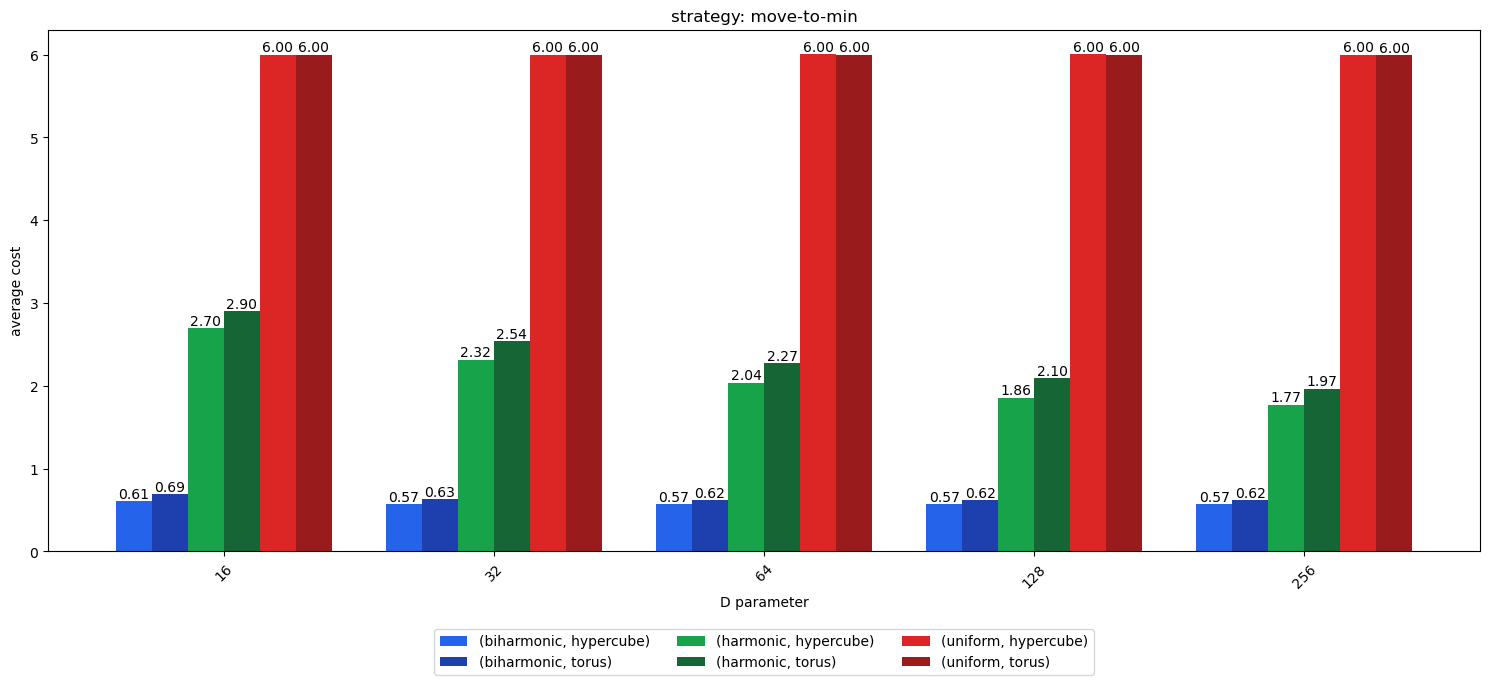

In [47]:
with open("results.pkl", "rb") as f:
    df = pickle.load(f)

color_map = {
    ("uniform", "hypercube"): "#dc2626",
    ("uniform", "torus"): "#991b1b",
    ("geometric", "hypercube"): "#ca8a04",
    ("geometric", "torus"): "#854d0e",
    ("harmonic", "hypercube"): "#16a34a",
    ("harmonic", "torus"): "#166534",
    ("biharmonic", "hypercube"): "#2563eb",
    ("biharmonic", "torus"): "#1e40af"
}

for strategy_name, strategy_df in df.groupby('strategy'):
    fig, ax = plt.subplots(figsize=(15, 7))
    pivot_df = strategy_df.pivot_table(index='d_value', columns=['distribution', 'graph_type'], values='result')
    bar_colors = [color_map.get((dist, graph), "black") for dist, graph in pivot_df.columns]
    pivot_df.plot(kind='bar', ax=ax, width=0.8, color=bar_colors)

    for container in ax.containers:
        ax.bar_label(container, label_type='edge', fmt='%.2f')

    ax.set_title(f'strategy: {strategy_name}')
    ax.set_ylabel('average cost')
    ax.set_xlabel('D parameter')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=len(pivot_df.columns)//2)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.savefig(f"plots/cost_per_strategy_{strategy_name}.png")
    plt.show()

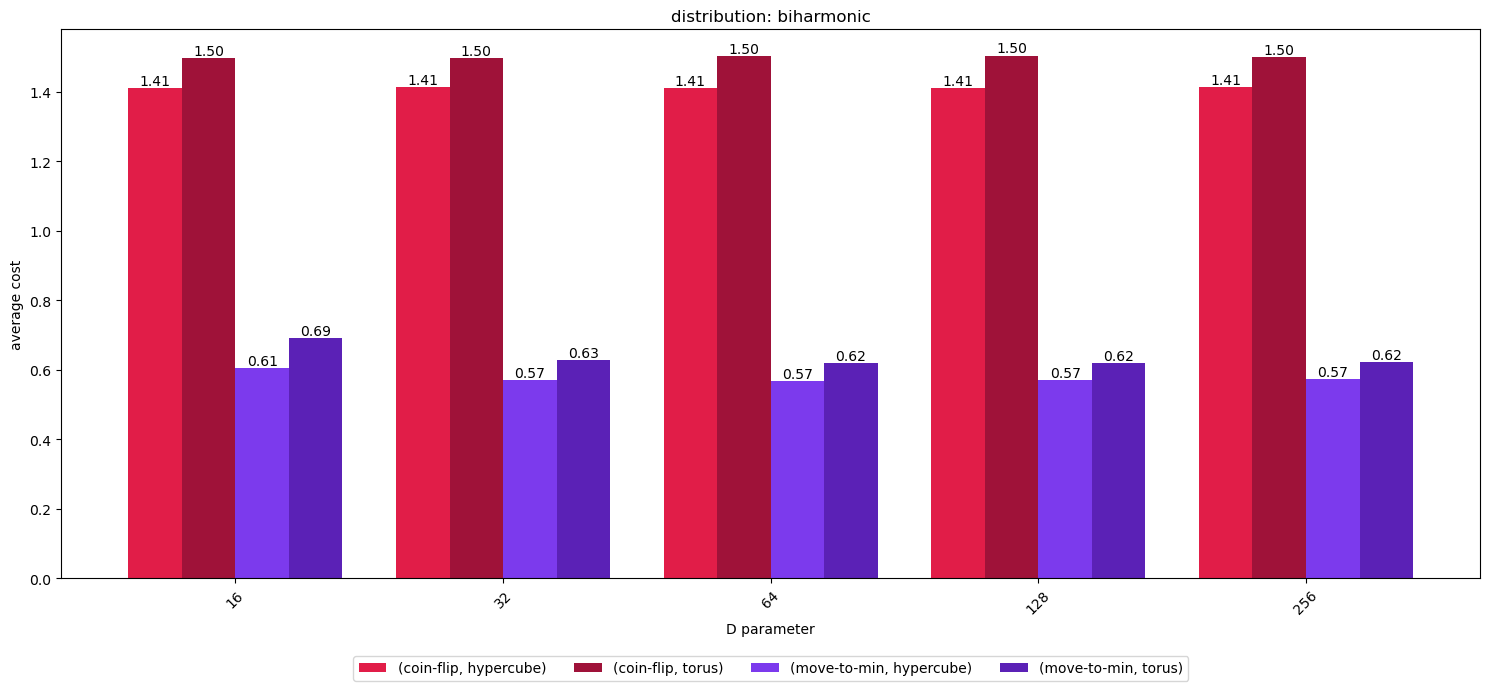

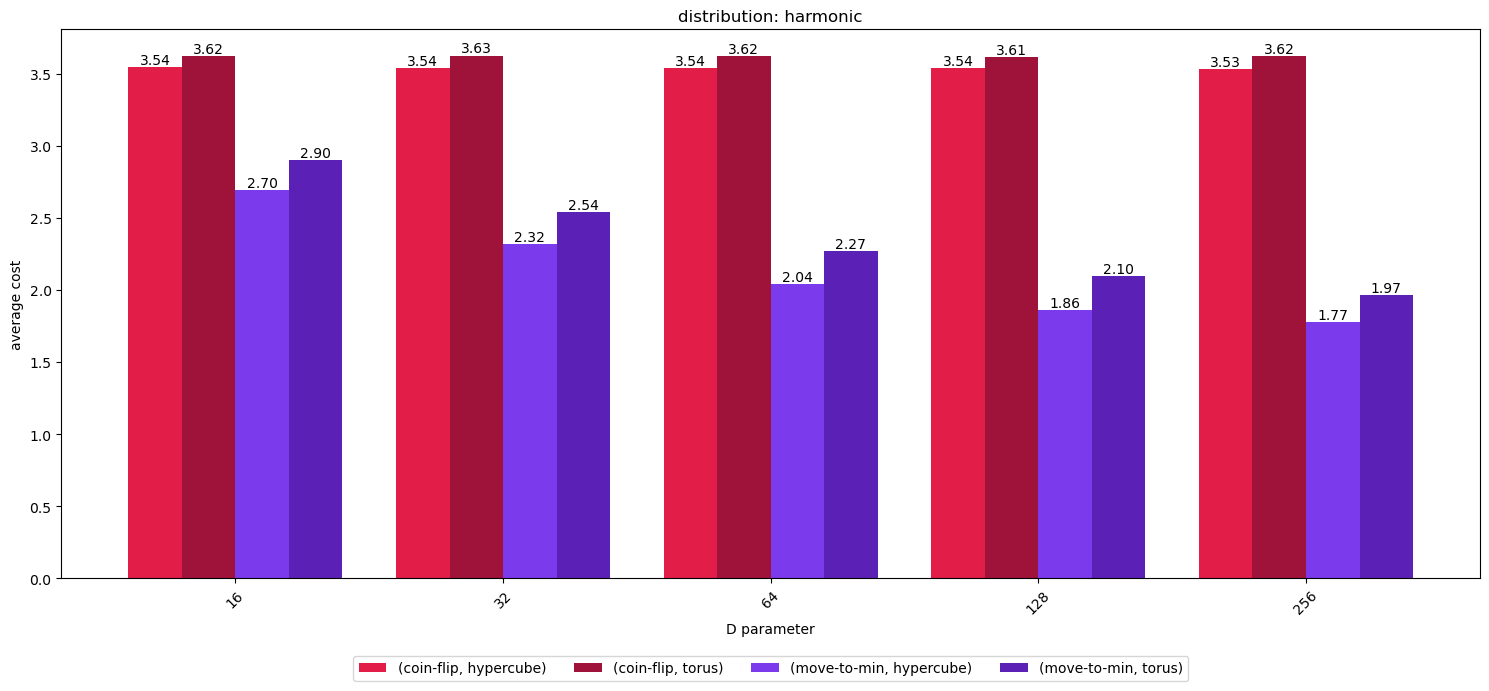

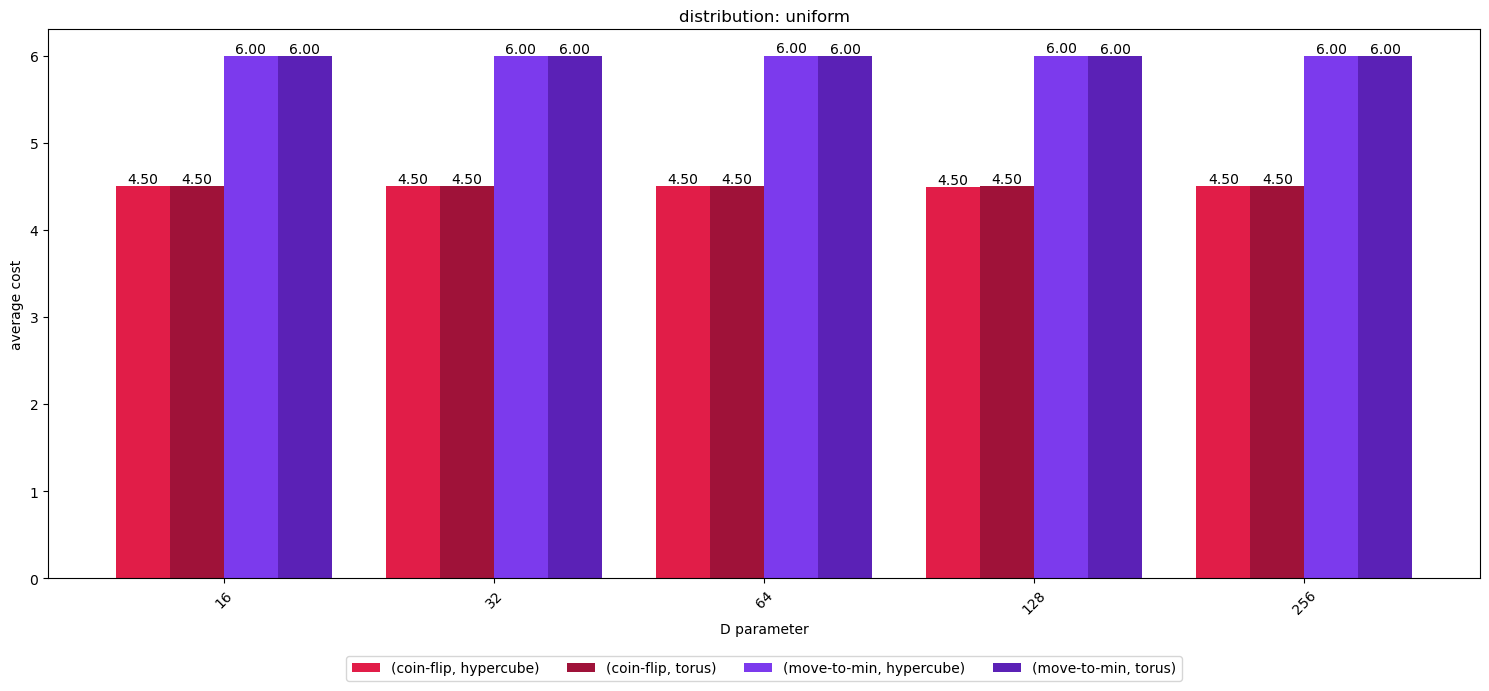

In [48]:
with open("results.pkl", "rb") as f:
    df = pickle.load(f)

color_map = {
    ("coin-flip", "hypercube"): "#e11d48",
    ("coin-flip", "torus"): "#9f1239",
    ("move-to-min", "hypercube"): "#7c3aed",
    ("move-to-min", "torus"): "#5b21b6"
}

for distribution_name, distribution_df in df.groupby('distribution'):
    fig, ax = plt.subplots(figsize=(15, 7))
    pivot_df = distribution_df.pivot_table(index='d_value', columns=['strategy', 'graph_type'], values='result')
    bar_colors = [color_map.get((strategy, graph), "black") for strategy, graph in pivot_df.columns]
    pivot_df.plot(kind='bar', ax=ax, width=0.8, color=bar_colors)

    for container in ax.containers:
        ax.bar_label(container, label_type='edge', fmt='%.2f')

    ax.set_title(f'distribution: {distribution_name}')
    ax.set_ylabel('average cost')
    ax.set_xlabel('D parameter')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(pivot_df.columns))

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.savefig(f"plots/cost_per_distribution_{distribution_name}.png")
    plt.show()